## UMAP clustering on re-trained with k-maens 300 epochs (without PCA)   
    - 102 epochs initial (kmeans)
    - 200 additional epochs (kmeans)
    - train data:
    
```
Haus8 sgRNA #1	190219_195942-V	B12	
Haus8 sgRNA #2	190219_195942-V	E1	
Haus8 sgRNA #3	190219_195942-V	F2	
Haus8 sgRNA #4	190219_195942-V	G2	
DyncH1 sgRNA #3	190219_195942-V	A1	
Incenp sgRNA #1	190219_195942-V	G4	
Incenp sgRNA #2	190219_195942-V	G6	
Incenp sgRNA #3	190219_195942-V	H1	
Rad21 sgRNA #1	190219_195942-V	H3	
Rad21 sgRNA #2	190219_195942-V	H5	
Rad21 sgRNA #3	190219_195942-V	H7
```
    - test: 

```
Incenp sgRNA #1	190219_195942-V	G5	
Incenp sgRNA #2	190219_195942-V	G8	
No sgRNA Pt13_r02_c12
```
    - clustering with K-means, spectral, ward, agglomerative, OPTICS, birch

Additional cluster comparisons  
Also using 2 UMAP dimensions for clustering

In [1]:
import time
import matplotlib.pyplot as plt
import os
import numpy as np
import anndata as ad
import torch
from sklearn.decomposition import PCA
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from PIL import Image
from torch.autograd import Variable
from util import load_model
from util import AverageMeter, Logger, UnifLabelSampler
import shutil
import seaborn as sn
import scanpy.api as sc
import pandas as pd

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
model=load_model('/home/aogorodnikov/model_alex_kmeans300/checkpoint.pth.tar')

=> loading checkpoint '/home/aogorodnikov/model_alex_kmeans300/checkpoint.pth.tar'
Loaded


In [4]:
model.cuda()
model.eval()


AlexNet(
  (features): Sequential(
    (0): Conv2d(2, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace)
    (11): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace)
    (14): Conv2d(384, 256, kernel_si

In [5]:
model.top_layer = None
model.classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [6]:
def compute_features(dataloader, model, N):
    
    batch_time = AverageMeter()
    end = time.time()
    model.eval()
    # discard the label information in the dataloader
    for i, (input_tensor, _) in enumerate(dataloader):
        with torch.no_grad():
            input_var = torch.autograd.Variable(input_tensor.cuda())
            aux = model(input_var).data.cpu().numpy()
            if i == 0:
                features = np.zeros((N, aux.shape[1])).astype('float32')

            if i < len(dataloader) - 1:
                features[i * 256: (i + 1) * 256] = aux.astype('float32')
            else:
                # special treatment for final batch
                features[i * 256:] = aux.astype('float32')

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()
        

    return features

In [7]:
data_dir = '/home/aogorodnikov/eval'

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
tra = [transforms.Resize(256),
       transforms.CenterCrop(224),
       transforms.ToTensor(),
       normalize]
dataset = datasets.ImageFolder(data_dir, transform=transforms.Compose(tra))
dataloader = torch.utils.data.DataLoader(dataset,
                                         batch_size=256,
                                         num_workers=8,
                                         pin_memory=True)



In [8]:
%%time
features = compute_features(dataloader, model, len(dataset))

CPU times: user 2min 8s, sys: 2min 37s, total: 4min 46s
Wall time: 4min 14s


In [9]:
features.shape

(203428, 4096)

In [10]:
np.random.seed(33)

In [11]:
# get the file names
dataset.samples[0][0]
samples = [x[0] for x in dataset.samples]


In [12]:
# construct AnnData obj
adata = ad.AnnData(X=features, obs = samples)
adata.obs["well"] = adata.obs.iloc[:,0].str.extract(r'(Pt\d+_r\d+c\d+)')
adata.obs["image_ID"] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]



In [13]:
# downsample data
adata = adata[np.random.choice(range(0,adata.shape[0]), size=round(adata.shape[0]*0.2), replace=False),:]

In [14]:
adata

View of AnnData object with n_obs × n_vars = 40686 × 4096 
    obs: 0, 'well', 'image_ID'

### UMAP embedding without PCA

In [15]:
# Dimension reduction and clustering libraries
import umap

In [16]:
# euclidean

reducer = umap.UMAP(random_state=42, min_dist=0.0, n_components=2)
embedding_euc = reducer.fit_transform(adata.X)

## Clustering approaches

## K-means

In [17]:
from sklearn.cluster import KMeans

In [23]:
labels = KMeans(init='k-means++', n_clusters=200, n_init=30).fit(embedding_euc).labels_

In [24]:
labels


array([ 26,  54, 118, ..., 153,  33,   9], dtype=int32)

In [18]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
data - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(data, param):
    labels = KMeans(init='k-means++', n_clusters=param, n_init=10).fit(data).labels_
    df_emb = pd.DataFrame(data)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [19]:
# loop over parameters of clustering
params = [10,20,50,80,100,200,300]
max_difference = [dif_clust(embedding_euc, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

In [20]:
max_difference_df

0          1          2          3           4           5  \
0  10.000000  20.000000  50.000000  80.000000  100.000000  200.000000   
1   1.686647   1.819401   2.466289   4.809622    3.867142    5.545736   

            6  
0  300.000000  
1    5.587161

In [25]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

df_emb.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003   ,27
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006   ,43
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015   ,78
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017   ,43
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018  ,196

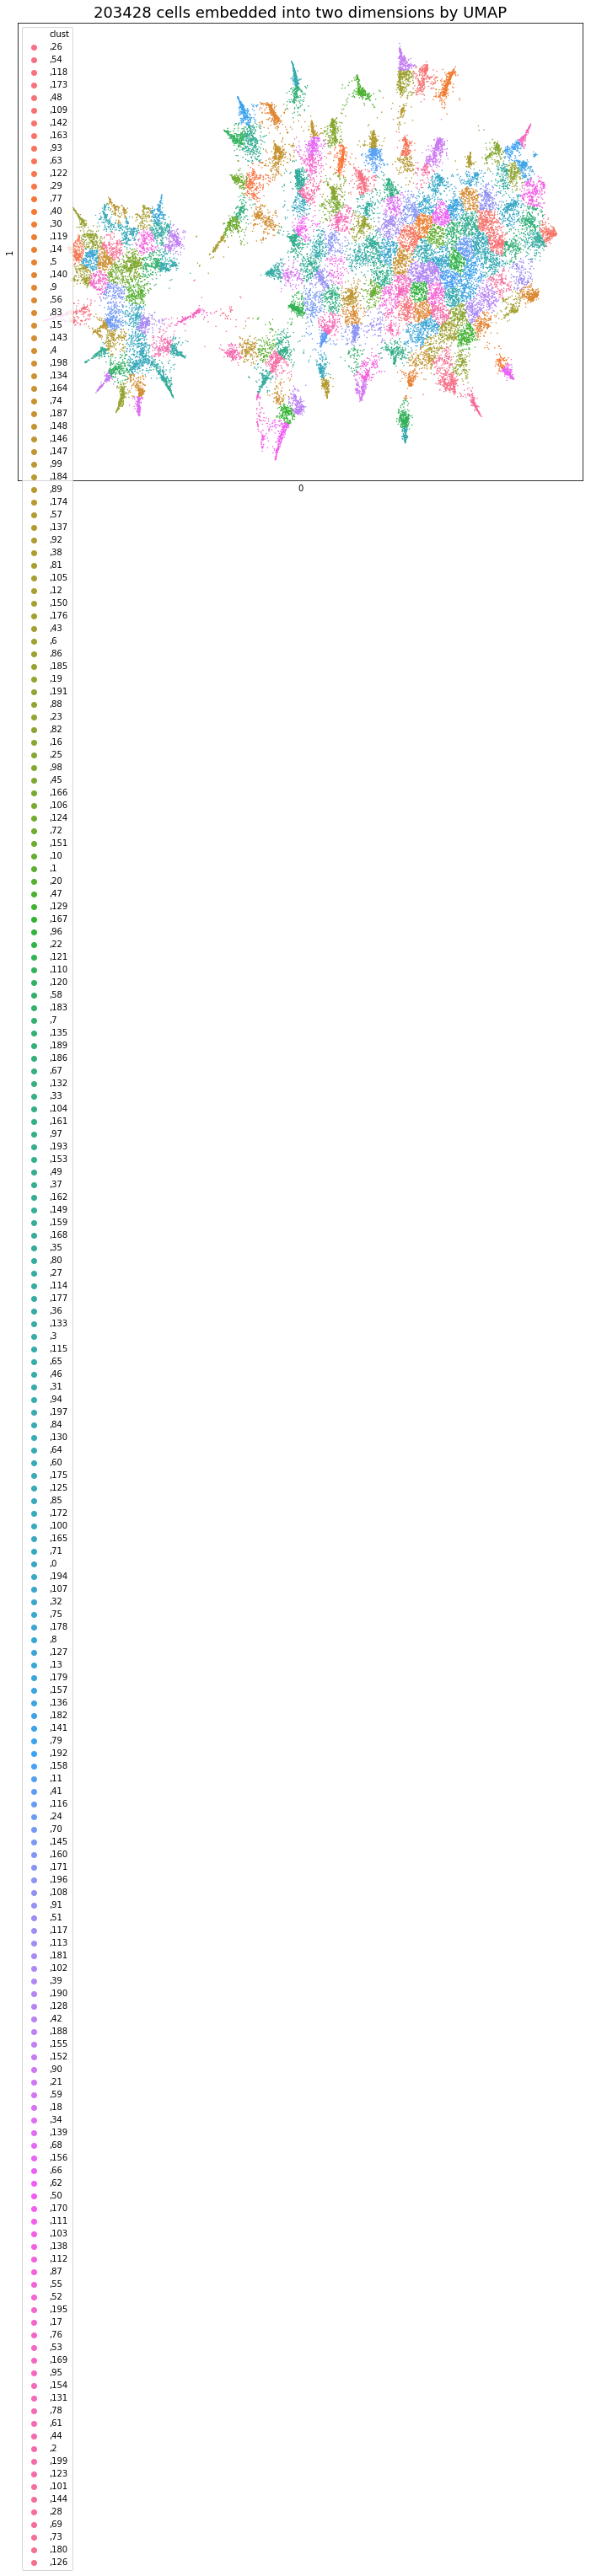

In [26]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [44]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == 1 else ",".join(['', str(0)]) for x in labels]


df_emb_clust.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003    ,0
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006    ,0
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015    ,0
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017    ,0
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018    ,0

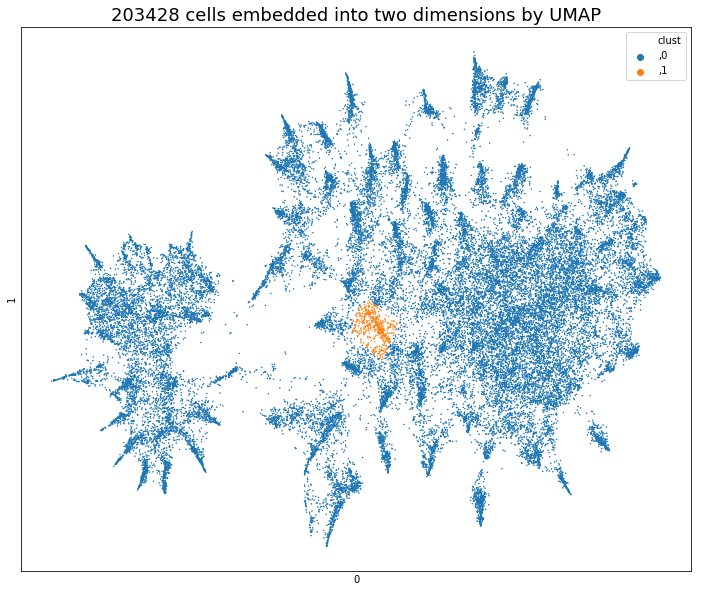

In [45]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [27]:
## kmeans
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [28]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [29]:
clust_df.head()

well class     n_samp
0  Pt04_r07c08   ,26  79.118395
1  Pt04_r07c08   ,54  78.411981
2  Pt04_r07c08  ,118  47.329754
3  Pt04_r07c08  ,173  52.981068
4  Pt04_r07c08   ,48  65.696524

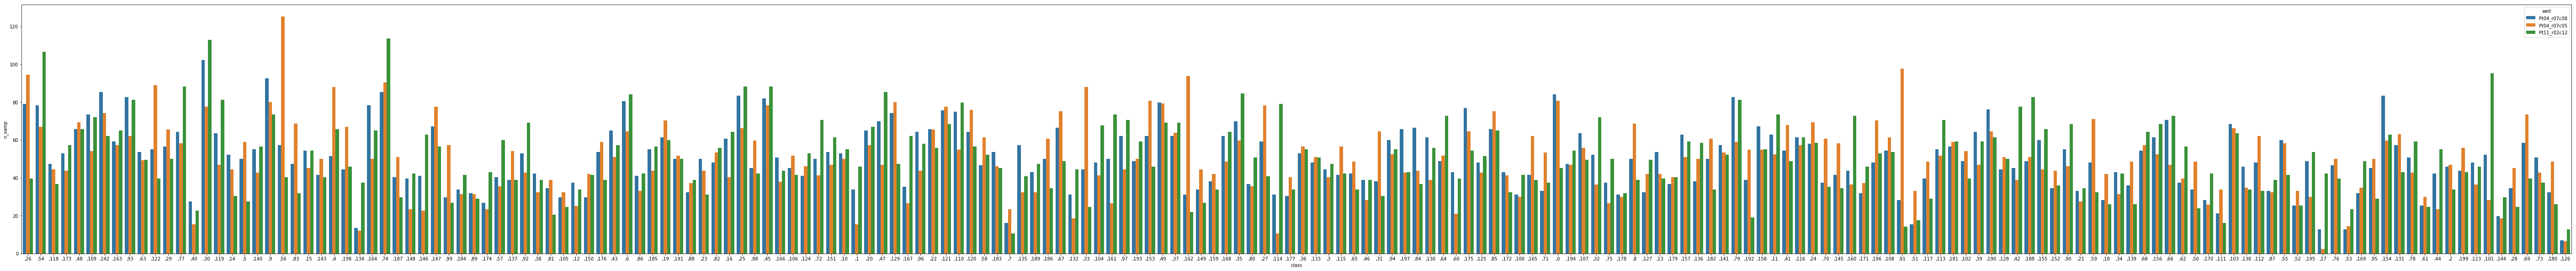

In [31]:
fig, ax = plt.subplots(figsize=(100, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [32]:
import re
import cv2

In [33]:
df_emb.head()

0         1         well              image_ID clust
0  3.113234 -3.057437  Pt04_r07c08  Pt04_r07c08_f76_0425   ,26
1  0.884884  1.453785  Pt04_r07c05  Pt04_r07c05_f86_0485   ,54
2 -6.958601 -1.473656  Pt04_r07c08  Pt04_r07c08_f30_0263  ,118
3  2.270180 -1.528339  Pt04_r07c05  Pt04_r07c05_f25_0429  ,173
4 -6.937983 -1.432529  Pt04_r07c05  Pt04_r07c05_f39_0480  ,118

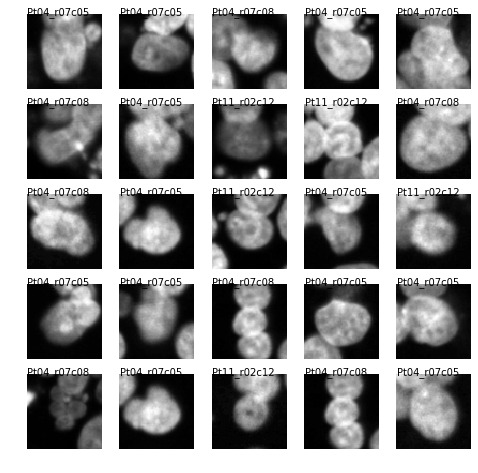

In [35]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',31', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### conclusion k-means  
biggest difference pos control to negative controls (7.347984) is with 200 clusters. Too many clusters.

## Ward hierarchical

In [46]:
from sklearn.cluster import AgglomerativeClustering

In [47]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
x - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(x, param):
    labels = AgglomerativeClustering(n_clusters=param, linkage='ward',connectivity=None).fit_predict(x)
    df_emb = pd.DataFrame(x)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [48]:
# loop over parameters of clustering
params = [10,20,50,80,100,200,300]
max_difference = [dif_clust(embedding_euc, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

In [49]:
max_difference_df

0          1         2          3           4          5  \
0  10.000000  20.000000  50.00000  80.000000  100.000000  200.00000   
1   1.873837   1.873837   2.52131   4.067673    4.528737    6.06086   

            6  
0  300.000000  
1    6.444544

In [50]:
labels = AgglomerativeClustering(n_clusters=80, linkage='ward',connectivity=None).fit_predict(embedding_euc)

In [51]:
labels


array([46, 73, 20, ..., 43,  3, 59])

In [52]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

df_emb.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003   ,11
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006   ,10
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015   ,32
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017   ,10
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018    ,3

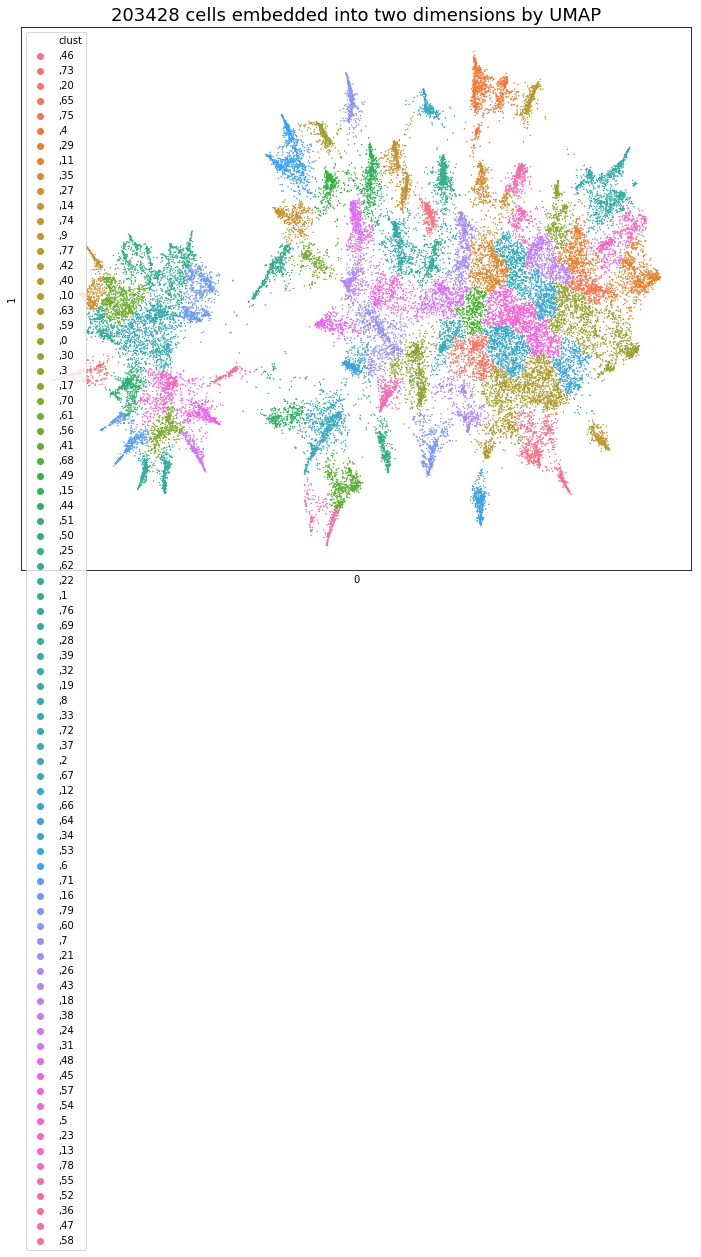

In [53]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [61]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == 7 else ",".join(['', str(0)]) for x in labels]


df_emb_clust.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003    ,0
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006    ,0
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015    ,0
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017    ,0
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018    ,0

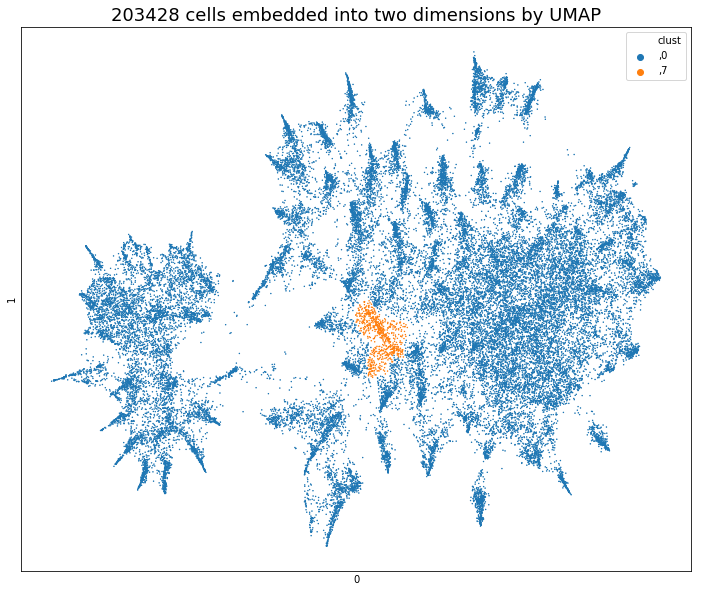

In [62]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [56]:
# cluster
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [57]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [58]:
clust_df.head()

well class      n_samp
0  Pt04_r07c08   ,46  146.227748
1  Pt04_r07c08   ,73   76.292738
2  Pt04_r07c08   ,20   72.760667
3  Pt04_r07c08   ,65  163.181690
4  Pt04_r07c08   ,75  120.090421

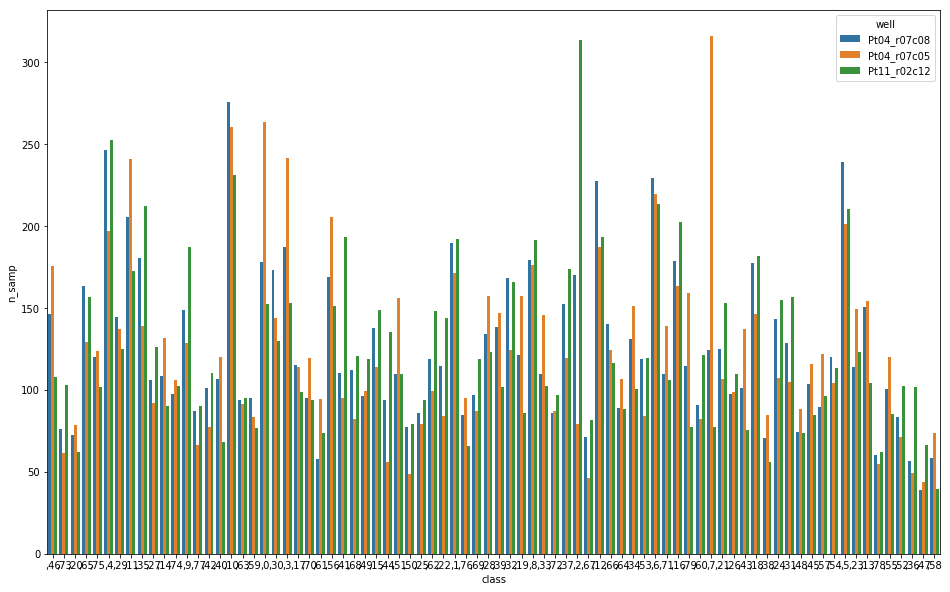

In [59]:
fig, ax = plt.subplots(figsize=(16, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [49]:
import re
import cv2

In [50]:
df_emb.head()

0         1         well              image_ID clust
0  5.645845 -1.017744  Pt04_r07c05  Pt04_r07c05_f26_0400    ,5
1 -6.398620  1.142287  Pt04_r07c05  Pt04_r07c05_f85_0943   ,12
2 -2.469002  2.944870  Pt11_r02c12  Pt11_r02c12_f57_0398    ,6
3  3.607288 -1.152244  Pt04_r07c05  Pt04_r07c05_f71_0559    ,8
4  2.632505 -0.568566  Pt11_r02c12  Pt11_r02c12_f15_0839    ,3

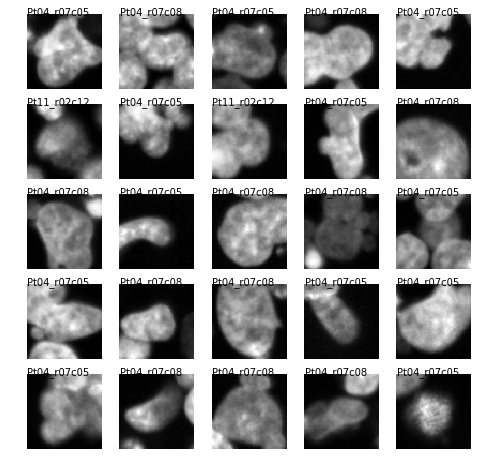

In [60]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',7', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### Ward hierarchical conclusion  
biggest difference pos control to negative controls (6.444544) is with 300 clusters. Too many clusters.

## Manhattan hierarchical

In [63]:
from sklearn.cluster import AgglomerativeClustering

In [64]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
x - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(x, param):
    labels = AgglomerativeClustering(n_clusters=param, linkage='complete',connectivity=None, affinity="cityblock").fit_predict(x)
    df_emb = pd.DataFrame(x)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [65]:
# loop over parameters of clustering
params = [10,20,50,80,100,200,300]
max_difference = [dif_clust(embedding_euc, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


In [66]:
max_difference_df

0          1          2         3          4      5      6
0  10.000000  20.000000  50.000000  80.00000  100.00000  200.0  300.0
1   1.478207   1.775892   2.207802   2.42204    5.07809    inf    inf

### Manhattan hierarchical conclusion  
biggest difference pos control to negative controls (5.07809) is with 100 clusters. Too many clusters.

## DBSCAN

In [67]:
from sklearn.cluster import DBSCAN

In [68]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
x - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(x, param):
    labels = DBSCAN(eps=param, min_samples=10).fit_predict(x)
    df_emb = pd.DataFrame(x)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [69]:
# loop over parameters of clustering
params = [0.1,0.2,0.5,0.8,1,2,3]
max_difference = [dif_clust(embedding_euc, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars


In [70]:
max_difference_df

0    1    2    3    4    5    6
0  0.1  0.2  0.5  0.8  1.0  2.0  3.0
1  inf  inf  1.0  1.0  1.0  1.0  1.0

In [80]:
labels = DBSCAN(eps=0.1, min_samples=10).fit_predict(embedding_euc)

In [81]:
labels


array([ 0,  1,  2, ...,  0, -1,  0])

In [82]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

df_emb.sort_values('image_ID').head()




0         1         well              image_ID clust
30422  3.054311  1.749035  Pt04_r07c05  Pt04_r07c05_f01_0010    ,0
34079  0.371556 -1.893806  Pt04_r07c05  Pt04_r07c05_f01_0024    ,0
37342  4.884090 -1.345757  Pt04_r07c05  Pt04_r07c05_f01_0025    ,0
35738  4.715926 -0.997975  Pt04_r07c05  Pt04_r07c05_f01_0026    ,0
11134  2.122411 -0.818709  Pt04_r07c05  Pt04_r07c05_f01_0033    ,0

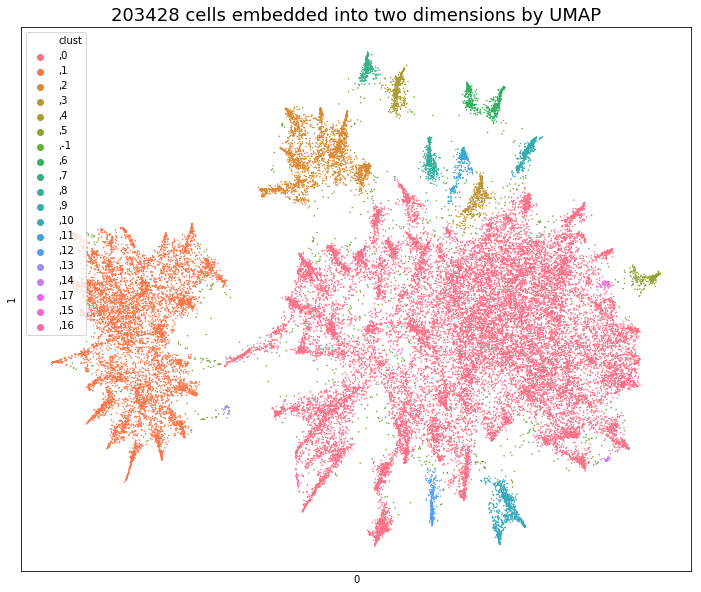

In [83]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [98]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == 5 else ",".join(['', str(0)]) for x in labels]


df_emb_clust.sort_values('image_ID').head()




0         1         well              image_ID clust
30422  3.054311  1.749035  Pt04_r07c05  Pt04_r07c05_f01_0010    ,0
34079  0.371556 -1.893806  Pt04_r07c05  Pt04_r07c05_f01_0024    ,0
37342  4.884090 -1.345757  Pt04_r07c05  Pt04_r07c05_f01_0025    ,0
35738  4.715926 -0.997975  Pt04_r07c05  Pt04_r07c05_f01_0026    ,0
11134  2.122411 -0.818709  Pt04_r07c05  Pt04_r07c05_f01_0033    ,0

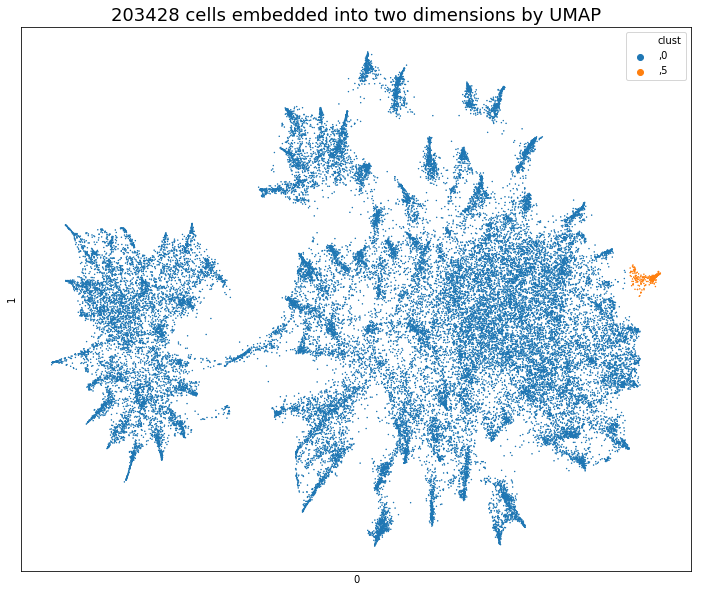

In [99]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [86]:
# cluster
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [87]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [88]:
clust_df.head()

well class       n_samp
0  Pt04_r07c05    ,0  6138.685544
1  Pt04_r07c05    ,1  2169.576060
2  Pt04_r07c05    ,2   559.086156
3  Pt04_r07c05    ,3    74.008527
4  Pt04_r07c05    ,4   100.555064

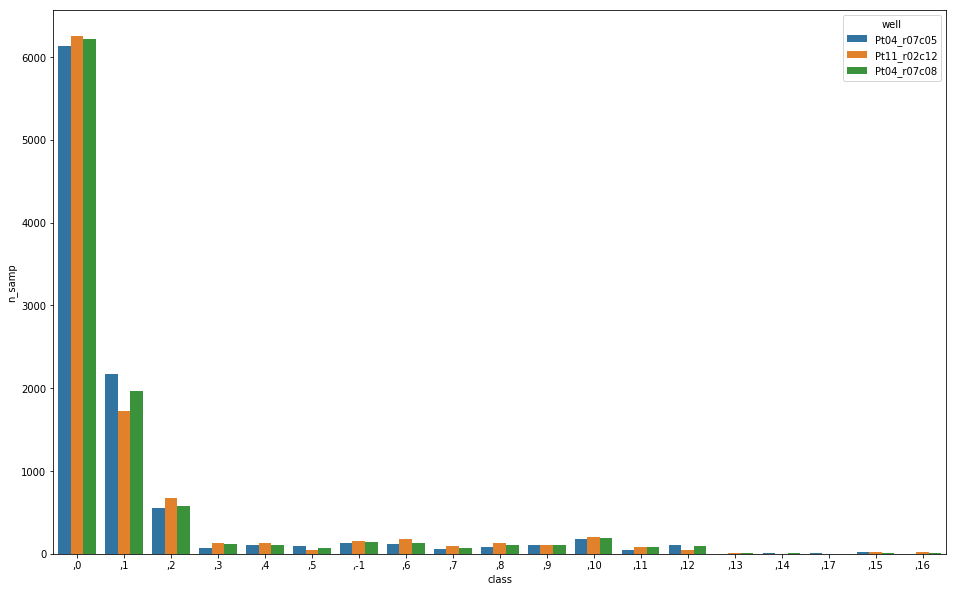

In [89]:
fig, ax = plt.subplots(figsize=(16, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [92]:
import re
import cv2

In [93]:
df_emb.head()

0         1         well              image_ID clust
0  5.645845 -1.017744  Pt04_r07c05  Pt04_r07c05_f26_0400    ,0
1 -6.398620  1.142287  Pt04_r07c05  Pt04_r07c05_f85_0943    ,1
2 -2.469002  2.944870  Pt11_r02c12  Pt11_r02c12_f57_0398    ,2
3  3.607288 -1.152244  Pt04_r07c05  Pt04_r07c05_f71_0559    ,0
4  2.632505 -0.568566  Pt11_r02c12  Pt11_r02c12_f15_0839    ,0

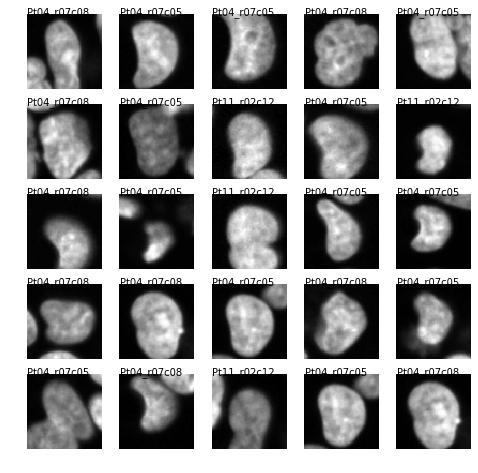

In [101]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',5', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### DBSCAN conclusion  
biggest difference pos control to negative controls (5.716354) is with `eps` 0.1. Still not enough. Also unstable, sometimes don't cluster at all.

## Birch

In [71]:
from sklearn.cluster import Birch

In [72]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
x - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(x, param):
    labels = Birch(branching_factor=50, n_clusters=None, threshold=param, compute_labels=True).fit_predict(x)
    df_emb = pd.DataFrame(x)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [73]:
# loop over parameters of clustering
params = [0.05,0.1,0.2,0.3,0.4,0.5,0.8,1]
max_difference = [dif_clust(embedding_euc, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in double_scalars
/home/aogorodnikov/anaconda3/envs/imgSudoku/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


In [74]:
max_difference_df

0    1    2         3         4         5         6         7
0  0.05  0.1  0.2  0.300000  0.400000  0.500000  0.800000  1.000000
1   inf  inf  inf  6.625232  4.265335  4.738358  1.959518  1.902978

In [82]:
labels = Birch(branching_factor=50, n_clusters=None, threshold=0.5, compute_labels=True).fit_predict(embedding_euc)

In [83]:
labels


array([42, 29, 23, ..., 15, 39, 14])

In [84]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

df_emb.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003   ,57
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006   ,59
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015   ,58
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017   ,59
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018   ,51

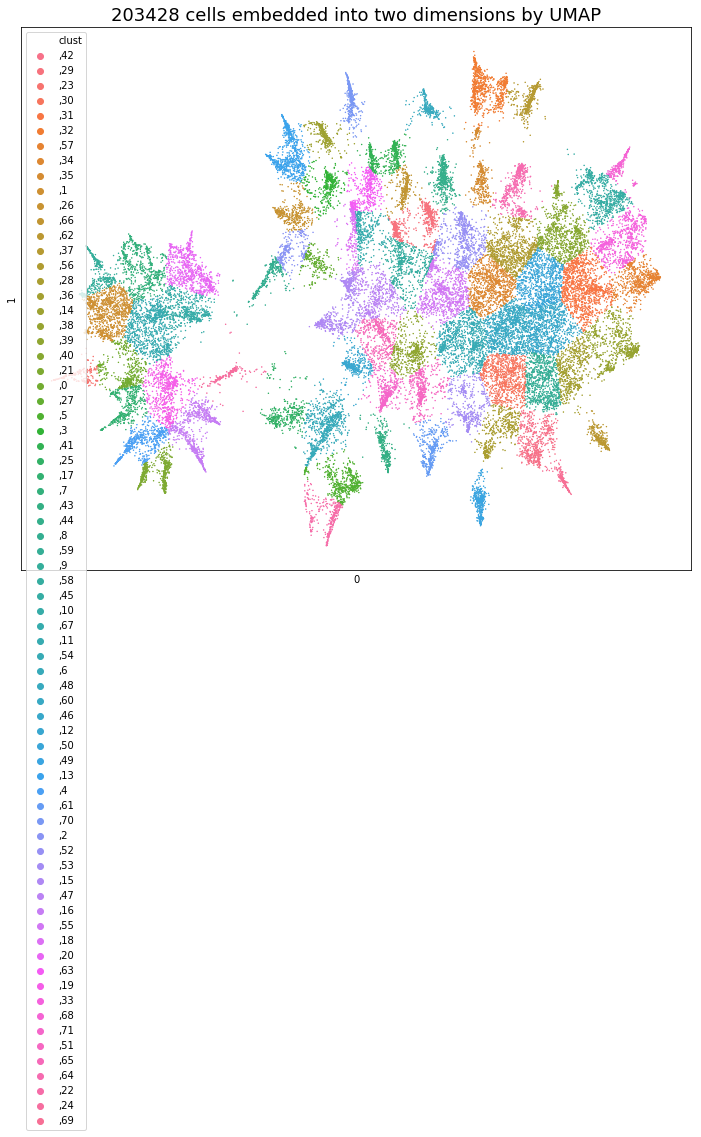

In [85]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [95]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == 65 else ",".join(['', str(0)]) for x in labels]


df_emb_clust.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003    ,0
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006    ,0
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015    ,0
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017    ,0
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018    ,0

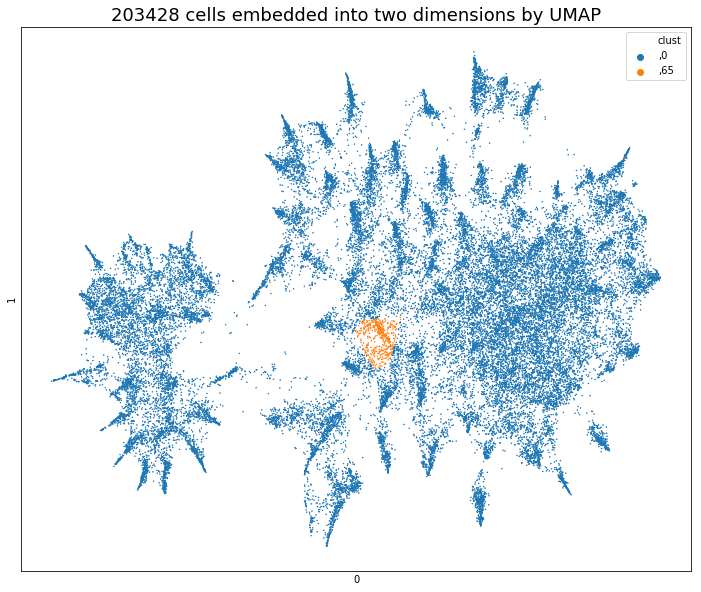

In [96]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [88]:
# cluster
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [89]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [90]:
clust_df.head()

well class      n_samp
0  Pt04_r07c08   ,42  140.576434
1  Pt04_r07c08   ,29  159.649619
2  Pt04_r07c08   ,23   55.806725
3  Pt04_r07c08   ,30  230.291043
4  Pt04_r07c08   ,31  324.950551

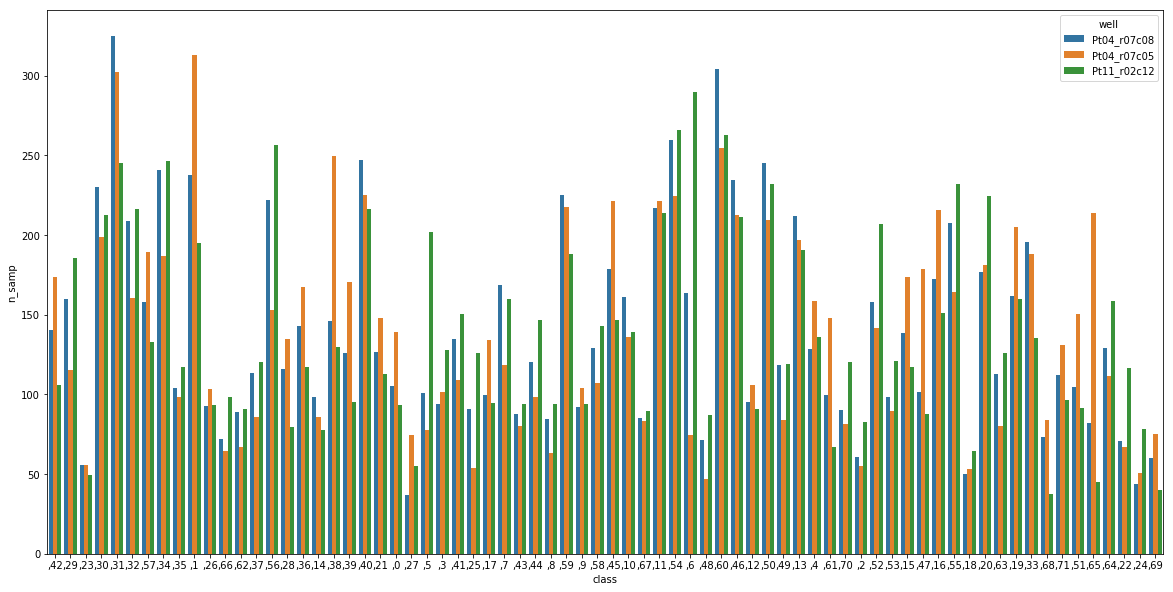

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [92]:
import re
import cv2

In [98]:
df_emb.head()

0         1         well              image_ID clust
0  3.113234 -3.057437  Pt04_r07c08  Pt04_r07c08_f76_0425   ,42
1  0.884884  1.453785  Pt04_r07c05  Pt04_r07c05_f86_0485   ,29
2 -6.958601 -1.473656  Pt04_r07c08  Pt04_r07c08_f30_0263   ,23
3  2.270180 -1.528339  Pt04_r07c05  Pt04_r07c05_f25_0429   ,30
4 -6.937983 -1.432529  Pt04_r07c05  Pt04_r07c05_f39_0480   ,23

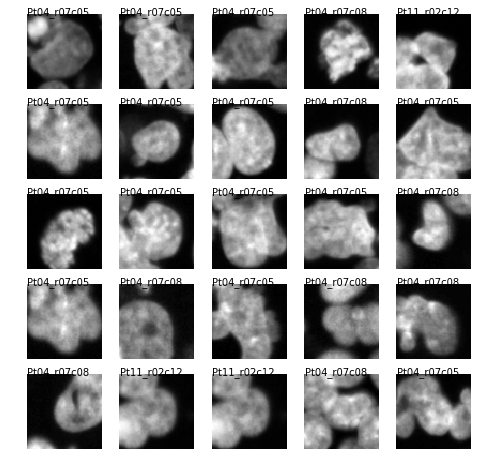

In [94]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',65', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### Birch 
biggest difference pos control to negative controls (6.625232) is with 0.3 threshold. > 200 clusters with those settings.

## Louvain

In [20]:
adata

View of AnnData object with n_obs × n_vars = 40686 × 4096 
    obs: 0, 'well', 'image_ID'

In [21]:
%%time
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')

CPU times: user 47.9 s, sys: 0 ns, total: 47.9 s
Wall time: 41.6 s


In [32]:
%%time
sc.tl.louvain(adata, resolution=2.5)

CPU times: user 5.16 s, sys: 0 ns, total: 5.16 s
Wall time: 4.95 s


In [23]:
embedding_euc

array([[ 3.1132343e+00, -3.0574372e+00],
       [ 8.8488442e-01,  1.4537854e+00],
       [-6.9586015e+00, -1.4736558e+00],
       ...,
       [-9.4641292e-01,  8.4578089e-02],
       [-2.7598371e-03, -1.4005460e+00],
       [-1.5749965e+00,  2.7369058e+00]], dtype=float32)

In [26]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['louvain'] = ["_".join(['lol', x]) for x in adata.obs["louvain"]]

In [28]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
data - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(data, param):
    sc.tl.louvain(data, resolution=param)
    df_emb = pd.DataFrame(embedding_euc)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in adata.obs['louvain']]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [29]:
# loop over parameters of clustering
params = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3]
max_difference = [dif_clust(adata, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

In [30]:
max_difference_df

0         1         2         3         4         5         6  \
0  0.250000  0.500000  0.750000  1.000000  1.500000  2.000000  2.500000   
1  1.645537  1.811901  2.204727  2.165002  2.294836  2.244548  3.270396   

          7  
0  3.000000  
1  2.605964

In [33]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in adata.obs["louvain"]]

df_emb.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003   ,18
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006    ,4
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015   ,22
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017   ,19
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018   ,31

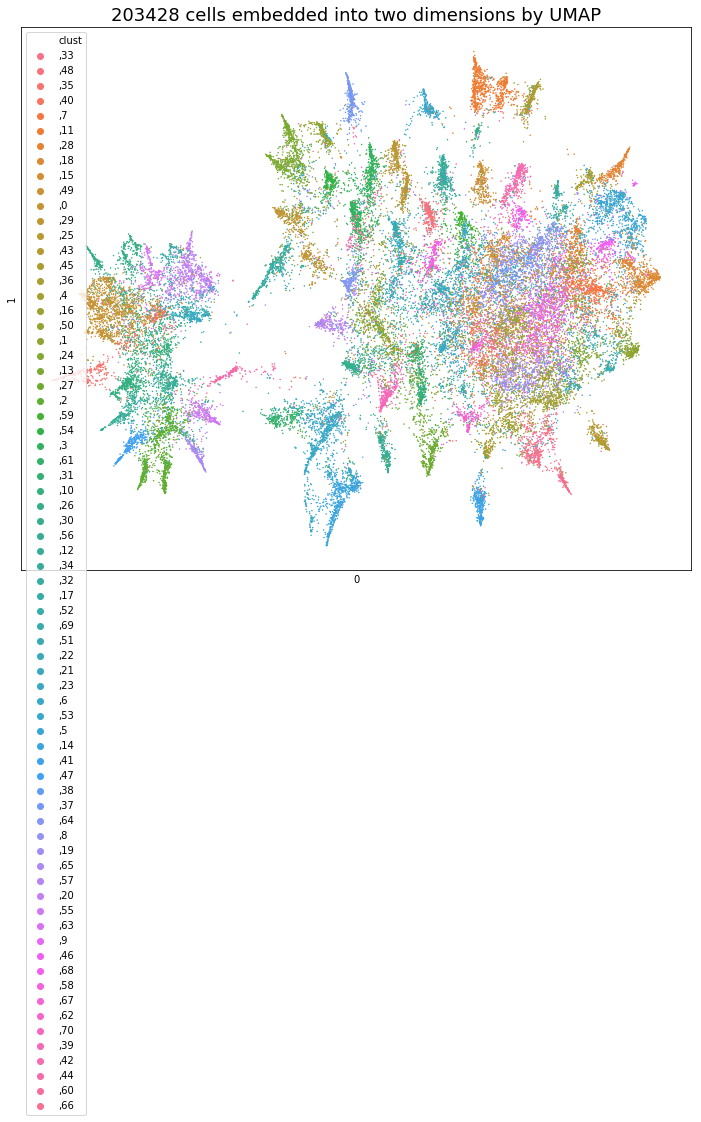

In [34]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [54]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == '1' else ",".join(['', str(0)]) for x in adata.obs["louvain"]]


df_emb_clust.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003    ,0
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006    ,0
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015    ,0
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017    ,0
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018    ,0

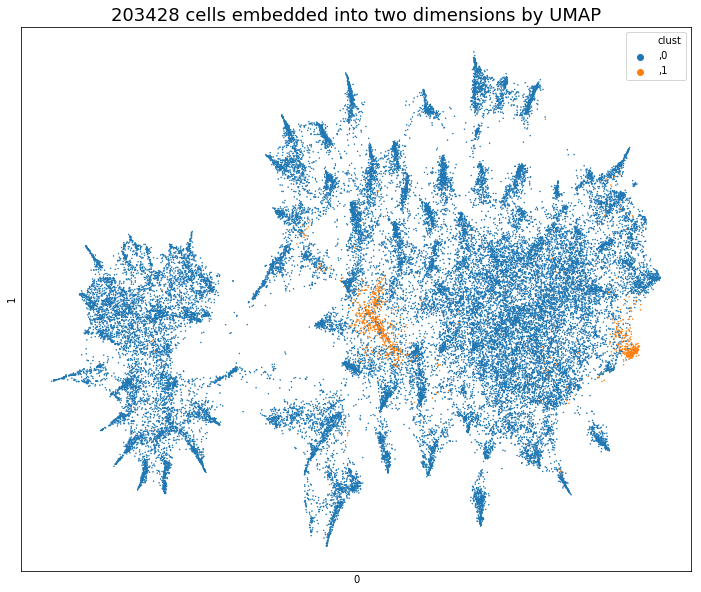

In [55]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [38]:
# cluster
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [39]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [40]:
clust_df.head()

well class      n_samp
0  Pt04_r07c08   ,33  132.805877
1  Pt04_r07c08   ,48   81.237638
2  Pt04_r07c08   ,35  120.090421
3  Pt04_r07c08   ,40  115.145521
4  Pt04_r07c08    ,7  263.492512

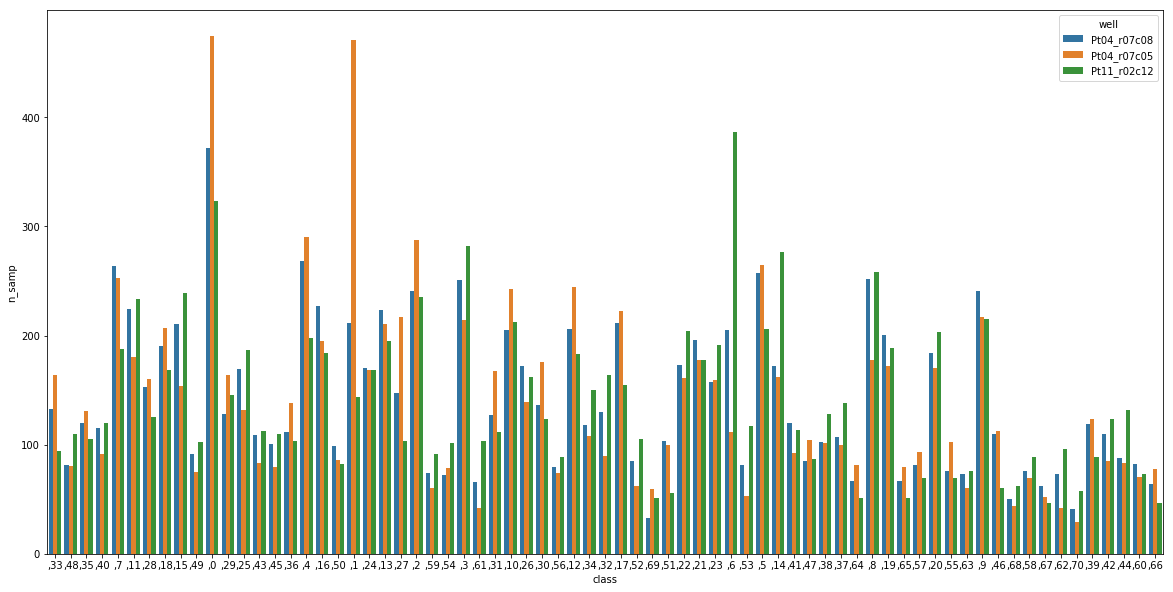

In [41]:
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [42]:
import re
import cv2

In [43]:
df_emb.head()

0         1         well              image_ID clust
0  3.113234 -3.057437  Pt04_r07c08  Pt04_r07c08_f76_0425   ,33
1  0.884884  1.453785  Pt04_r07c05  Pt04_r07c05_f86_0485   ,48
2 -6.958601 -1.473656  Pt04_r07c08  Pt04_r07c08_f30_0263   ,35
3  2.270180 -1.528339  Pt04_r07c05  Pt04_r07c05_f25_0429   ,40
4 -6.937983 -1.432529  Pt04_r07c05  Pt04_r07c05_f39_0480   ,35

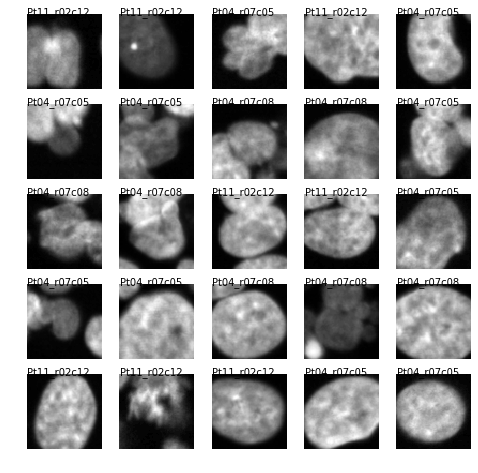

In [57]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',1', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### Louvain 
biggest difference pos control to negative controls (3.270396) is with 2.5 resolution. Difference too small.

## Leiden

In [20]:
adata

View of AnnData object with n_obs × n_vars = 40686 × 4096 
    obs: 0, 'well', 'image_ID'

In [21]:
%%time
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X')

CPU times: user 47.9 s, sys: 0 ns, total: 47.9 s
Wall time: 41.6 s


In [80]:
%%time
sc.tl.leiden(adata, resolution=2)

CPU times: user 14.3 s, sys: 0 ns, total: 14.3 s
Wall time: 13.9 s


In [59]:
embedding_euc

array([[ 3.1132343e+00, -3.0574372e+00],
       [ 8.8488442e-01,  1.4537854e+00],
       [-6.9586015e+00, -1.4736558e+00],
       ...,
       [-9.4641292e-01,  8.4578089e-02],
       [-2.7598371e-03, -1.4005460e+00],
       [-1.5749965e+00,  2.7369058e+00]], dtype=float32)

In [81]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['leiden'] = ["_".join(['lol', x]) for x in adata.obs["leiden"]]

In [77]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
data - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(data, param):
    sc.tl.leiden(data, resolution=param)
    df_emb = pd.DataFrame(embedding_euc)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in adata.obs['leiden']]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [78]:
# loop over parameters of clustering
params = [0.25, 0.5, 0.75, 1, 1.5, 2, 2.5, 3]
max_difference = [dif_clust(adata, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

In [79]:
max_difference_df

0         1         2         3         4         5         6  \
0  0.250000  0.500000  0.750000  1.000000  1.500000  2.000000  2.500000   
1  1.136047  1.801732  2.038765  2.753964  2.626912  3.421029  3.294365   

          7  
0  3.000000  
1  3.315171

In [82]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in adata.obs["leiden"]]

df_emb.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003   ,18
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006    ,7
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015   ,19
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017    ,7
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018   ,34

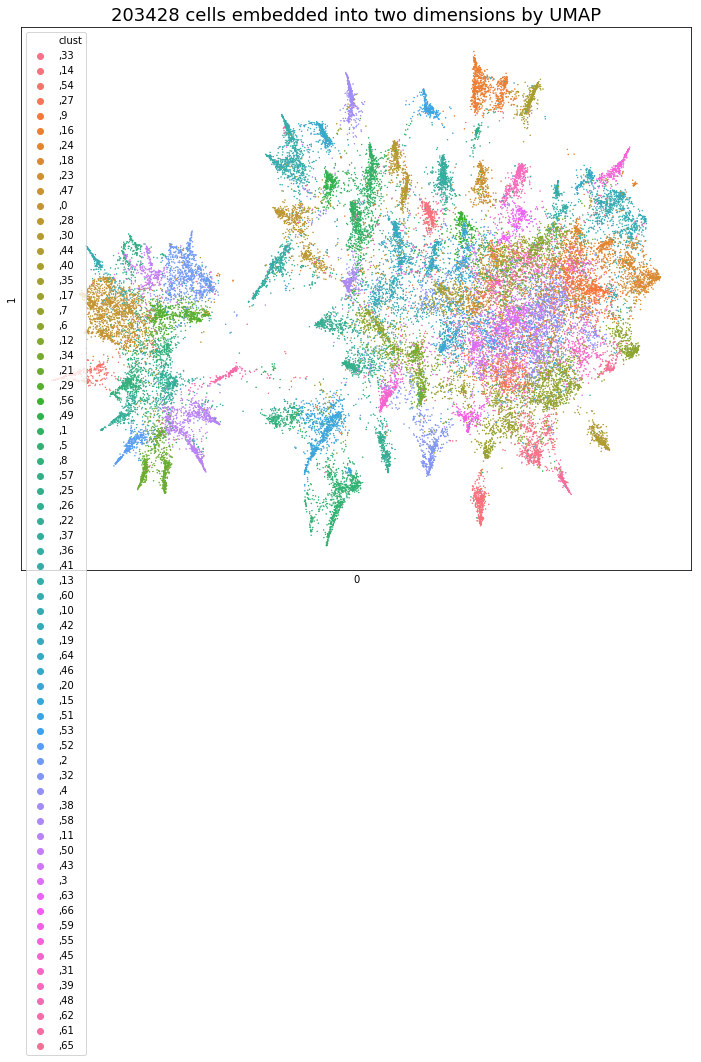

In [83]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [107]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == '6' else ",".join(['', str(0)]) for x in adata.obs["leiden"]]


df_emb_clust.sort_values('image_ID').head()




0         1         well              image_ID clust
35802  5.888779  0.038013  Pt04_r07c05  Pt04_r07c05_f01_0003    ,0
37634  3.579357 -1.939571  Pt04_r07c05  Pt04_r07c05_f01_0006    ,0
27236  0.475920  0.546883  Pt04_r07c05  Pt04_r07c05_f01_0015    ,0
11787  3.261851 -1.895822  Pt04_r07c05  Pt04_r07c05_f01_0017    ,0
11558  0.734706 -1.899009  Pt04_r07c05  Pt04_r07c05_f01_0018    ,0

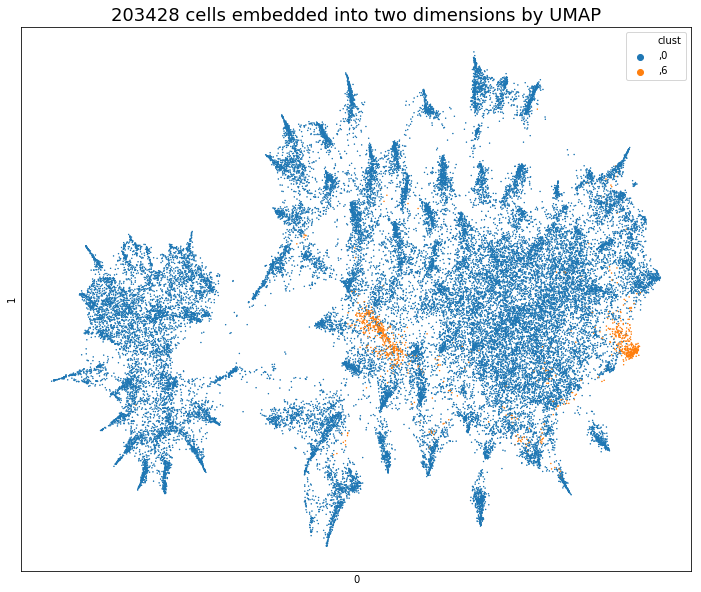

In [108]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [85]:
# cluster
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [91]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [92]:
clust_df.head()

well class      n_samp
0  Pt04_r07c08   ,33  144.814919
1  Pt04_r07c08   ,14  217.575586
2  Pt04_r07c08   ,54   76.999152
3  Pt04_r07c08   ,27  165.300932
4  Pt04_r07c08    ,9  248.657813

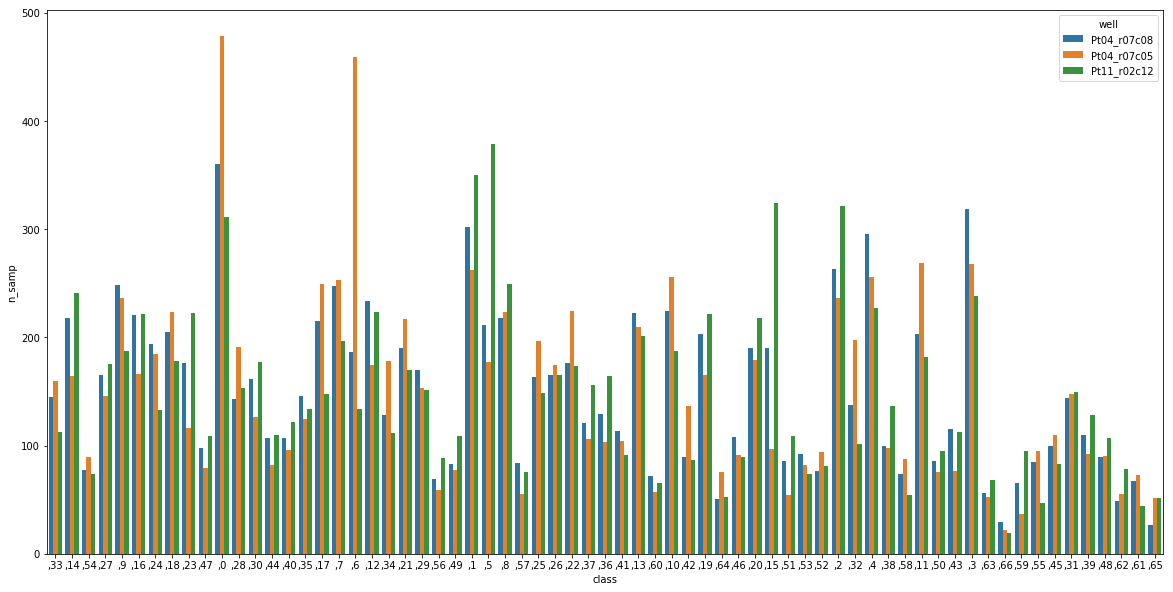

In [93]:
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [42]:
import re
import cv2

In [43]:
df_emb.head()

0         1         well              image_ID clust
0  3.113234 -3.057437  Pt04_r07c08  Pt04_r07c08_f76_0425   ,33
1  0.884884  1.453785  Pt04_r07c05  Pt04_r07c05_f86_0485   ,48
2 -6.958601 -1.473656  Pt04_r07c08  Pt04_r07c08_f30_0263   ,35
3  2.270180 -1.528339  Pt04_r07c05  Pt04_r07c05_f25_0429   ,40
4 -6.937983 -1.432529  Pt04_r07c05  Pt04_r07c05_f39_0480   ,35

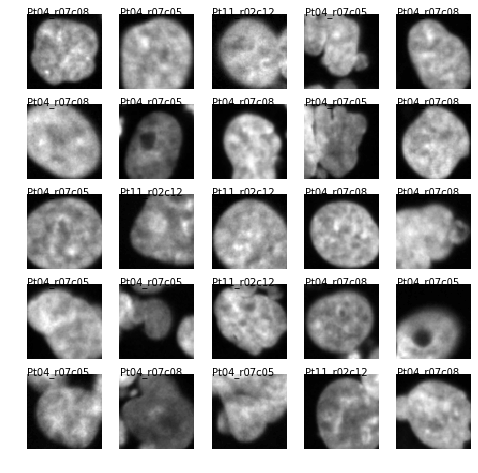

In [94]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',6', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### Leiden 
biggest difference pos control to negative controls (3.421029) is with 2.0 resolution. Difference too small. Also "target cluster" (cytokinesis defects) is split between 2 UMAP clouds

## ddCRP (distance-dependent chinese restuarant process)

needs neighbors (adjacency list)

In [71]:
from ddCRP import ddCRP
from ddCRP import Priors

In [ ]:
alpha=10
mu = 0
kappa = 0.0001
nu = 1
sigma = 1

nix = Priors.NIX2(mu0=mu, kappa0=kappa, nu0=nu, sigma0=sigma)

In [ ]:
crp = ddCRP.ddCRP(alpha, model=nix, mcmc_passes=30, stats_interval=200)
crp.fit("UMAP FEATURES HERE", "ADJACENCY LIST HERE")

## Need to return cluster labels

In [72]:
'''
function to loop over different clustering parametersand find clusters with highest difference b/w positive and negative controls
x - array (UMAP coordinates)
param - parameter to loop for
'''

def dif_clust(x, param):
    labels = Birch(branching_factor=50, n_clusters=None, threshold=param, compute_labels=True).fit_predict(x)
    df_emb = pd.DataFrame(x)
    df_emb['well'] = adata.obs["well"].tolist()
    df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
    df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

    clust_ls = []
    for well in df_emb.well.unique():
        sum_well = len(df_emb.clust[df_emb.well == well])
        for i in df_emb.clust.unique():
            res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
            clust_ls.append(res)
    clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])
    max_ratios = []
    for clust in clust_df['class'].unique():
        ns_ctrl = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt11_r02c12"), "n_samp"]
        ns_pos1 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c05"), "n_samp"]
        ns_pos2 = clust_df.loc[(clust_df['class'] == clust) & (clust_df['well'] == "Pt04_r07c08"), "n_samp"]
        max_ratios.append(max([ns_pos1.iloc[0]/ns_ctrl.iloc[0], ns_pos2.iloc[0]/ns_ctrl.iloc[0]]))
        
    return(max(max_ratios))

In [ ]:
# loop over parameters of clustering
params = [0.05,0.1,0.2,0.3,0.4,0.5,0.8,1]
max_difference = [dif_clust(embedding_euc, param) for param in params]
max_difference_df = pd.DataFrame([params, max_difference])

In [ ]:
max_difference_df

In [82]:
labels = Birch(branching_factor=50, n_clusters=None, threshold=0.5, compute_labels=True).fit_predict(embedding_euc)

In [ ]:
labels


In [ ]:
df_emb = pd.DataFrame(embedding_euc)
df_emb['well'] = adata.obs["well"].tolist()
df_emb['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb['clust'] = [",".join(['', str(x)]) for x in labels]

df_emb.sort_values('image_ID').head()




In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

In [ ]:
df_emb_clust = pd.DataFrame(embedding_euc)
df_emb_clust['well'] = adata.obs["well"].tolist()
df_emb_clust['image_ID'] = [os.path.splitext(os.path.basename(x))[0] for x in adata.obs.iloc[:,0]]
df_emb_clust['clust'] = [",".join(['', str(x)]) if x == 65 else ",".join(['', str(0)]) for x in labels]


df_emb_clust.sort_values('image_ID').head()




In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
sn.scatterplot(df_emb.iloc[:, 0], df_emb.iloc[:, 1], hue=df_emb_clust.clust, s=0.5, edgecolor=None)
plt.title("203428 cells embedded into two dimensions by UMAP", fontsize=18)
plt.setp(ax, xticks=[], yticks=[])


plt.show()

### Compare cluster sizes between samples  


In [ ]:
# cluster
clust_ls = []
for well in df_emb.well.unique():
    sum_well = len(df_emb.clust[df_emb.well == well])
    for i in df_emb.clust.unique():
        res = [well, i, len(df_emb.clust[(df_emb.clust == i) & (df_emb.well == well)]) / sum_well * 1e4]
        clust_ls.append(res)

In [ ]:
clust_df = pd.DataFrame(clust_ls, columns=['well', 'class', 'n_samp'])

In [ ]:
clust_df.head()

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
sn.barplot(x="class", y="n_samp", hue="well", data=clust_df)

### Clusters to export  


In [ ]:
import re
import cv2

In [ ]:
df_emb.head()

In [ ]:
fig=plt.figure(figsize=(8, 8))
columns = 5
rows = 5
for k in range(1, columns * rows + 1):
    select_im = df_emb.loc[df_emb.clust  == ',65', "image_ID"].to_list()
    rand_select = [select_im[x] for x in np.random.choice(range(1, len(select_im)), 1)][0]
    img_import = cv2.imread("".join(['/home/aogorodnikov/eval/data/',rand_select, ".tif"]), -1)
    subplot = fig.add_subplot(rows, columns, k)
    plt.text(0, 0, s=re.search(r'(Pt\d+_r\d+c\d+)', rand_select)[0])
    plt.imshow(img_import, cmap='gray');
    plt.axis('off')

### ddCRP  
biggest difference pos control to negative controls (6.625232) is with 0.3 threshold. > 200 clusters with those settings.

# CONCLUSIONS  
Test all same approaches with UMAP with higher number of dimensions